# [GD-10]KorEngTranslation(Transformer)

In [1]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker

import time
import re
import os
import io

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


In [2]:
# 한국어폰트지원
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("슝=3")

슝=3


## 1. 데이터 다운로드

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

In [4]:
with open(kor_path, "r") as f:
    raw_ko = f.read().splitlines()
    
print("Data Size: ", len(raw_ko))
print("Example: ")

for sen in raw_ko[0:100][::20]:
    print(">>", sen)

Data Size:  94123
Example: 
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [5]:
with open(eng_path, "r") as f:
    raw_en = f.read().splitlines()
    
print("Data Size: ", len(raw_en))
print("Example: ")

for sen in raw_en[0:100][::20]:
    print(">>", sen)

Data Size:  94123
Example: 
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.


## 2. 데이터 정제 및 토큰화

In [6]:
raw = zip(raw_ko, raw_en)

In [7]:
cleaned_corpus = set(raw)

In [8]:
len(cleaned_corpus)

78968

In [9]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    # 모든 입력을 소문자로 변환합니다.
    sentence = sentence.lower().strip()
    
    # 알파벳, 문장부호, 한글만 남기고 모두 제거합니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    # 한글 포함
    sentence = re.sub(r"[^a-zA-Z|0-9|ㄱ-하-ㅣ가-힣?.!,]+", " ", sentence)
    
    sentence = sentence.strip()
    
    return sentence

In [10]:
corpus_list = list(cleaned_corpus)

In [11]:
corpus_list[100]

('연합뉴스 기자는 ""그 모습은 마치 2004년 4월 김정일이 특별열차로 중국을 방문할 때와 상당히 비슷했다"" 고 전해왔다.',
 '""The scene was quite similar to one in April 2004, when Kim Jong-Il visited China by a special train,"" said South Korean news agency Yonhap.')

In [12]:
# 한글 말뭉치 kor_corpus 와 영문 말뭉치 eng_corpus 를 각각 분리
kor_corpus = []
eng_corpus = []

num_examples = len(corpus_list)

for pair in corpus_list[:num_examples]:
    ret_ko = preprocess_sentence(pair[0])
    ret_en = preprocess_sentence(pair[1], s_token=True, e_token=True)
    if len(ret_ko) <= num_examples:
        kor_corpus.append(ret_ko)
        eng_corpus.append(ret_en)
        
print(len(kor_corpus))
print(len(eng_corpus))
print("Korean :", kor_corpus[100])
print("English :", eng_corpus[100])

78968
78968
Korean : 연합뉴스 기자는 그 모습은 마치 2004년 4월 김정일이 특별열차로 중국을 방문할 때와 상당히 비슷했다 고 전해왔다 .
English : the scene was quite similar to one in april 2004 , when kim jong-il visited china by a special train , said south korean news agency yonhap .


In [13]:
# 토큰화
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    file = "./%s_corpus.txt" % lang
    model = "%s_spm" % lang
    
    with open(file, 'w') as f:
        for row in corpus: f.write('{}\n'.format(row))
    
    import sentencepiece as spm
    spm.SentencePieceTrainer.Train(
        '--input=./%s --model_prefix=%s --vocab_size=%d'\
        % (file, model, vocab_size) + \
        '--pad_id==%d --bos_id=%d --eos_id=%d --unk_id=%d'\
        % (pad_id, bos_id, eos_id, unk_id)
    )
    
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(('%s.model') % model)

    return tokenizer

In [14]:
VOCAB_SIZE = 7000
ko_tokenizer = generate_tokenizer(kor_corpus, VOCAB_SIZE, lang="ko")
en_tokenizer = generate_tokenizer(eng_corpus, VOCAB_SIZE, lang="en")

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=././ko_corpus.txt --model_prefix=ko_spm --vocab_size=7000--pad_id==0 --bos_id=1 --eos_id=2 --unk_id=3
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ././ko_corpus.txt
  input_format: 
  model_prefix: ko_spm
  model_type: UNIGRAM
  vocab_size: 7000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  

In [15]:
en_tokenizer.set_encode_extra_options('bos:eos')

True

In [16]:
from tqdm.notebook import tqdm    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
    ko_token = ko_tokenizer.encode_as_ids(kor_corpus[idx])
    en_token = en_tokenizer.encode_as_ids(eng_corpus[idx])
    
    if len(ko_token) > 50: continue
    if len(en_token) > 50: continue
    
    src_corpus.append(ko_token)
    tgt_corpus.append(en_token)
    
# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/78968 [00:00<?, ?it/s]

In [17]:
print(enc_train.shape)
print(dec_train.shape)

(67146, 50)
(67146, 50)


## 3. 모델 설계

In [18]:
# Positional Encoding
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    
    return sinusoid_table

print("슝=3")

슝=3


In [19]:
# Multi-Head Attention
# 여러 개의 서브 모듈을 결합하여 완성

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)    
        """
        Scaled QK 값 구하기
        """
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        # scaled_qk: Attention을 위한 Softmax 직전의 Scaled QK
        if mask is not None: scaled_qk += (mask * -1e9)  
        """
        1. Attention Weights 값 구하기 -> attentions
        2. Attention 값을 V에 곱하기 -> out
        """ 
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        """
        Embedding을 Head의 수로 분할하는 함수

        x: [ batch x length x emb ]
        return: [ batch x length x heads x self.depth ]
        """
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수

        x: [ batch x length x heads x self.depth ]
        return: [ batch x length x emb ]
        """
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out

        """
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        # split_heads(): Embedding된 입력을 Head 수로 분할
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        # scaled_dot_product_attention(): 분할된 입력으로부터 Attention 값을 구함
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
        
        # combine_heads(): 연산이 종료되고 분할된 Head를 다시 하나로 결합
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

In [20]:
# Position-wise Feed-Forward Network
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

print("슝=3")

슝=3


In [21]:
# Encoder 레이어 구현하기

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

print("슝=3")

슝=3


In [22]:
# Decoder 레이어 구현하기

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [23]:
# Encoder 클래스
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

print("슝=3")

슝=3


In [24]:
# Decoder 클래스
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

print("슝=3")

슝=3


In [25]:
# Transformer 완성하기
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True
                    ):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        """
        1. Embedding Layer 정의
        2. Positional Encoding 정의
        3. Encoder / Decoder 정의
        4. Output Linear 정의
        5. Shared Weights
        6. Dropout 정의
        """
        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))
            
    def embedding(self, emb, x):
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        return: [ batch x length x emb ]
        """
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        Step 3: Decoder(dec_in, enc_out, mask)
                -> dec_out, dec_attns, dec_enc_attns
        Step 4: Out Linear(dec_out) -> logits
        """
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns


In [26]:
# Masking
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    """
    generate_padding_mask(): Attention을 할 때에 
    <PAD> 토큰에도 Attention을 주는 것을 방지해 주는 역할
    """
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

print("슝=3")

슝=3


## 4. 훈련하기

In [27]:
n_layers = 2
d_model = 512
n_heads = 8
d_ff = 2048
dropout = 0.3
vocab_size = 7000

transformer = Transformer(n_layers=n_layers,
                         d_model=d_model,
                         n_heads=n_heads,
                         d_ff=d_ff,
                         dropout=dropout,
                         src_vocab_size=vocab_size,
                         tgt_vocab_size=vocab_size,
                         pos_len=200,
                         shared=True
                         )


In [28]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

In [29]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [30]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]
    gold = tgt[:, 1:]

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

     # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [31]:
def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [32]:
def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [33]:
def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [35]:
sentences = ['오바마는 대통령이다.', '시민들은 도시 속에 산다.', '커피는 필요 없다.', '일곱 명의 사망자가 발생했다.']

In [36]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [37]:
import random
from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 15

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    print('Translations' )
    for sentence in sentences:
        translate(sentence, transformer, ko_tokenizer, en_tokenizer)
    print()
    print('Hyperparameters' )
    print('n_layers :', n_layers)
    print('d_model :', d_model)
    print('n_heads : ', n_heads)
    print('d_ff :', d_ff)
    print('dropout :', dropout)
    print()
    print('TRAINING')
    print('Warmup Steps: 4000')
    print('Batch size : 64')
    print('Epoch At : ', epoch+1)

/tmp/ipykernel_3072/2523585652.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/1050 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: obama is a new york .
Input: 시민들은 도시 속에 산다.
Predicted translation: it s a very a .
Input: 커피는 필요 없다.
Predicted translation: it is not a  ⁇ 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a gunmen were killed in a hospital .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  1


  0%|          | 0/1050 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: obama has opened a second term in a series of president obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: they have addd in cities .
Input: 커피는 필요 없다.
Predicted translation: there is no reason for no .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a suicide bombing of a deadliest attack occurred .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  2


  0%|          | 0/1050 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: president obama is president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are very poor .
Input: 커피는 필요 없다.
Predicted translation: you don t need you don t need anything .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in addition , a deadly attacked by a deadly attacked by a deadly attack .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  3


  0%|          | 0/1050 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: obama s president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they re all of these cities .
Input: 커피는 필요 없다.
Predicted translation: there is no immediate word on that price of dec .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of those killed .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  4


  0%|          | 0/1050 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: oh , oh , what is president .
Input: 시민들은 도시 속에 산다.
Predicted translation: we re all live in a city .
Input: 커피는 필요 없다.
Predicted translation: caffeine is no risk .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  5


  0%|          | 0/1050 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: obama is president roh moo-hyun .
Input: 시민들은 도시 속에 산다.
Predicted translation: cities is where they grow .
Input: 커피는 필요 없다.
Predicted translation: coffee no coffee should not have any no choice .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people have been killed .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  6


  0%|          | 0/1050 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: obama is scheduled to hold on his campaign .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are poor cities in city .
Input: 커피는 필요 없다.
Predicted translation: there need no need for anyone .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a government soldier died in a hospital .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  7


  0%|          | 0/1050 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: president obama is expected to stay in his presidential term .
Input: 시민들은 도시 속에 산다.
Predicted translation: they re crowds of deforest cities in urban city .
Input: 커피는 필요 없다.
Predicted translation: there s no risk of rheuma .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven-year-old deaths were killed .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  8


  0%|          | 0/1050 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: obama will make up his presidential look at
Input: 시민들은 도시 속에 산다.
Predicted translation: they re crowd .
Input: 커피는 필요 없다.
Predicted translation: there is no riskier .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  9


  0%|          | 0/1050 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: president obamas will stay in .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens . cities in new cities
Input: 커피는 필요 없다.
Predicted translation: you need to rw cheaper .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven died .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  10


  0%|          | 0/1050 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: oh is uh , you re president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they re blocking city .
Input: 커피는 필요 없다.
Predicted translation: there is no risk . don t have been no need for lunch
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were uffed .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  11


  0%|          | 0/1050 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: obama is scheduled .
Input: 시민들은 도시 속에 산다.
Predicted translation: they live in city .
Input: 커피는 필요 없다.
Predicted translation: it doesn t have any questions for it
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at seven people were killed .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  12


  0%|          | 0/1050 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: obama is looking for president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they take down cities in sanling .
Input: 커피는 필요 없다.
Predicted translation: there is no rhon .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven civilian deaths were in control .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  13


  0%|          | 0/1050 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: obamas will become president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they live in city .
Input: 커피는 필요 없다.
Predicted translation: there is no injuries .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at seven of them were killed .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  14


  0%|          | 0/1050 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: obamas are insery .
Input: 시민들은 도시 속에 산다.
Predicted translation: residents were de cities .
Input: 커피는 필요 없다.
Predicted translation: there is no risk , for coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were all were by a group .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  15


Input: 시민들은 도시 속에 산다.
Predicted translation: residents were de cities .
Encoder Layer 1


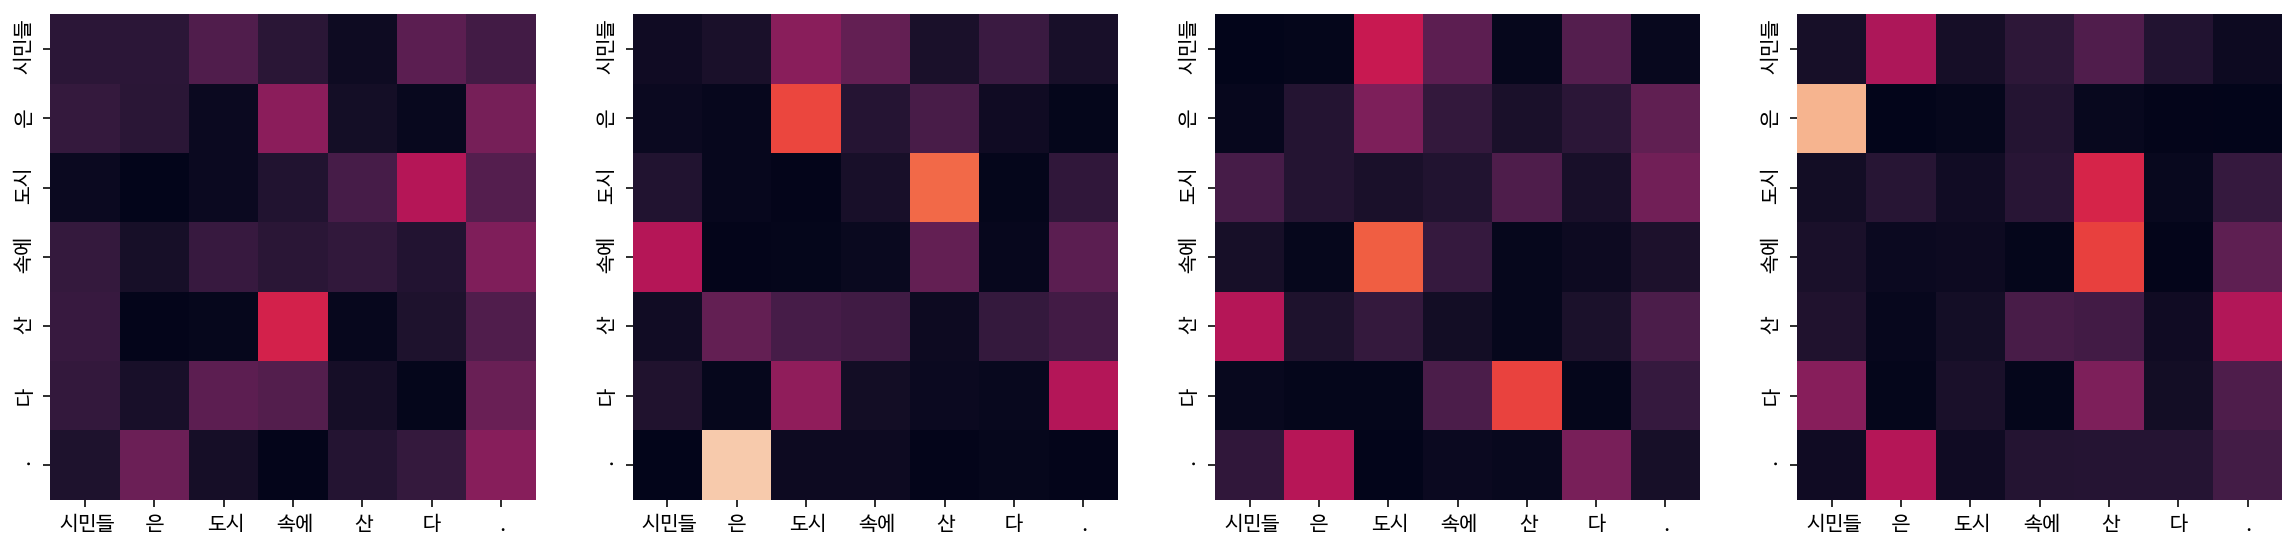

Encoder Layer 2


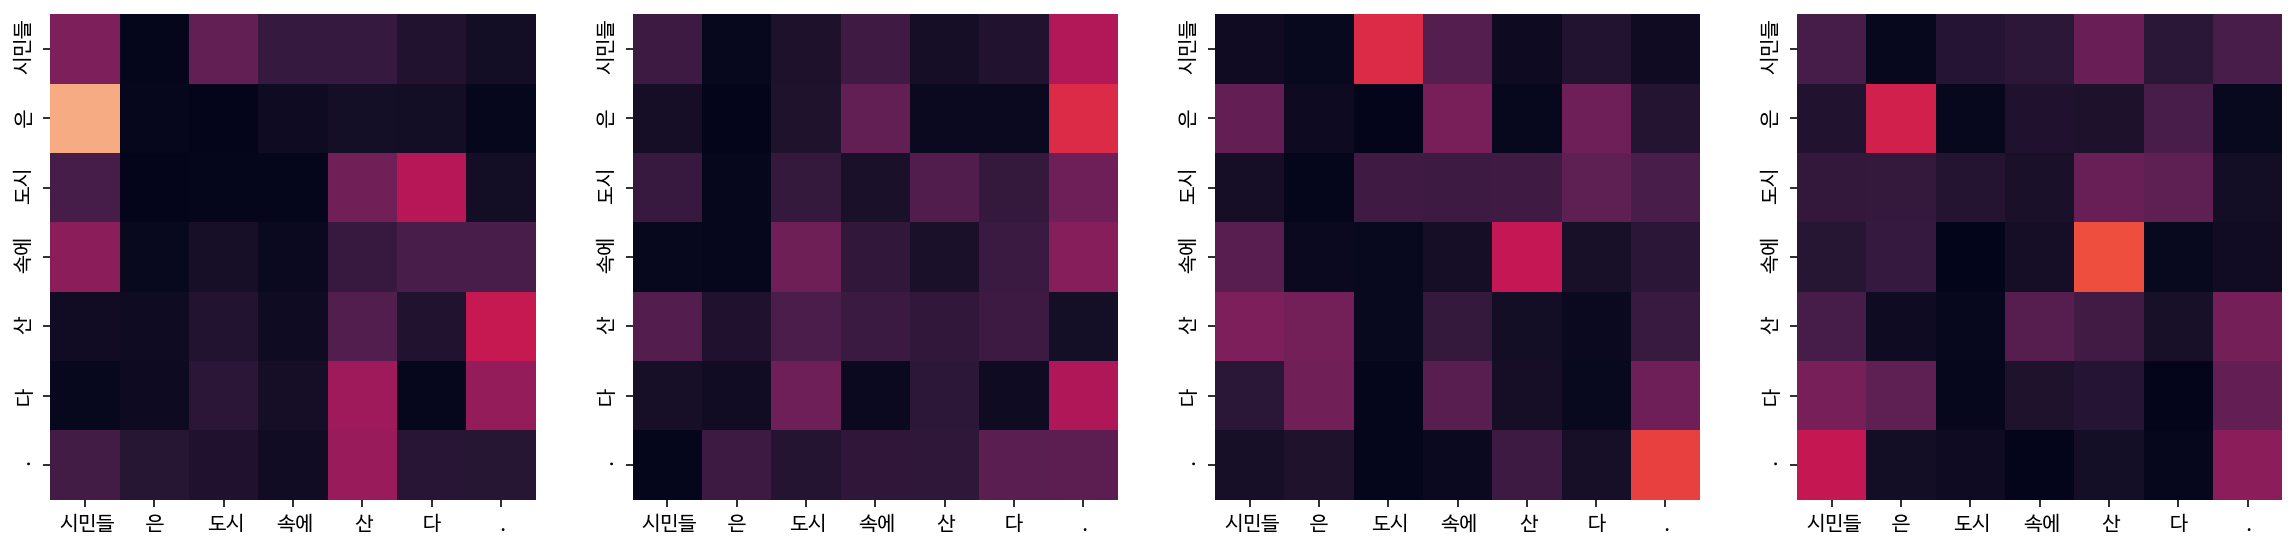

Decoder Self Layer 1


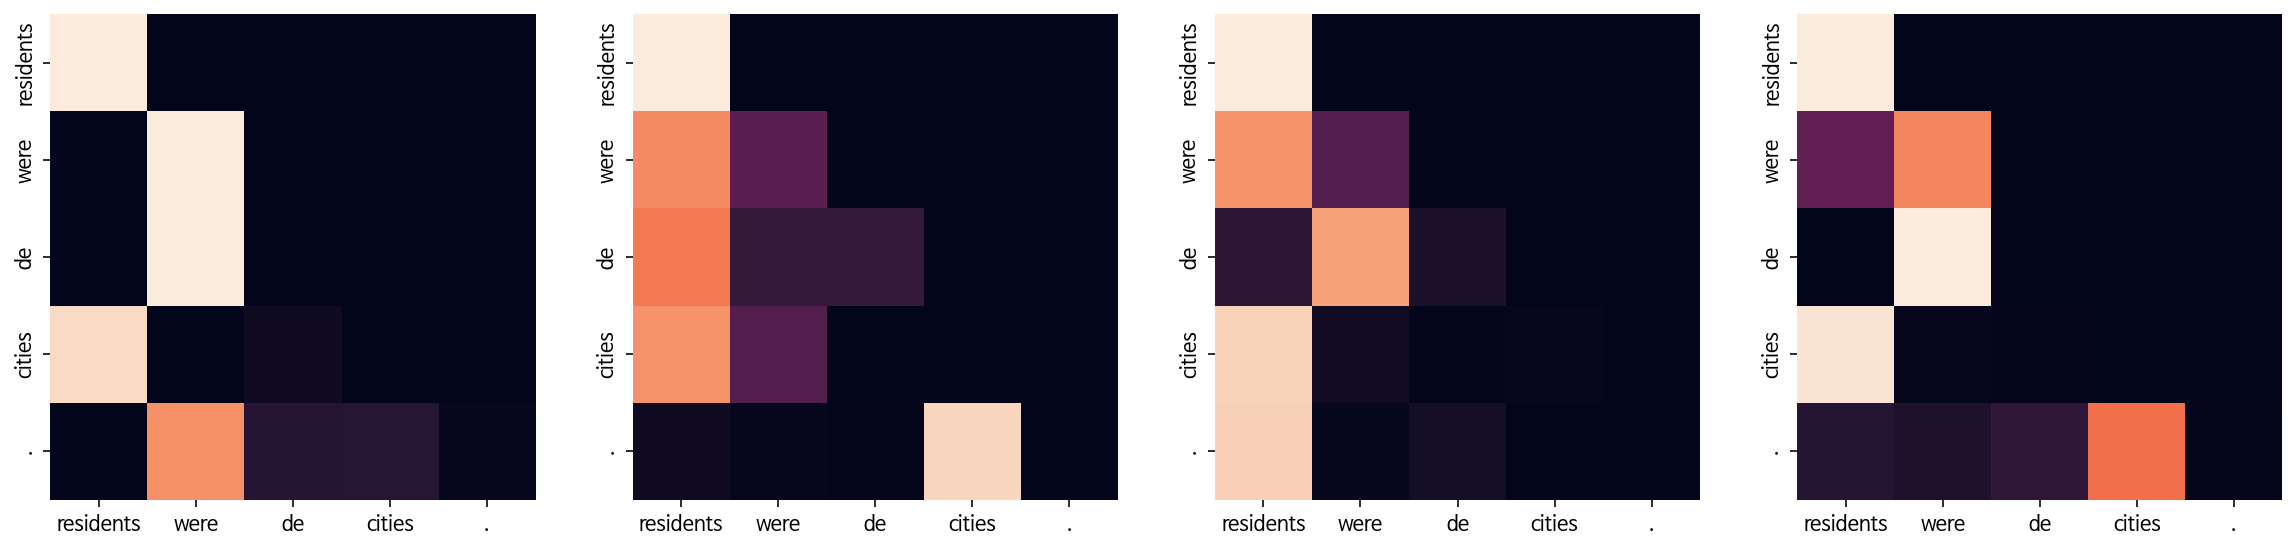

Decoder Src Layer 1


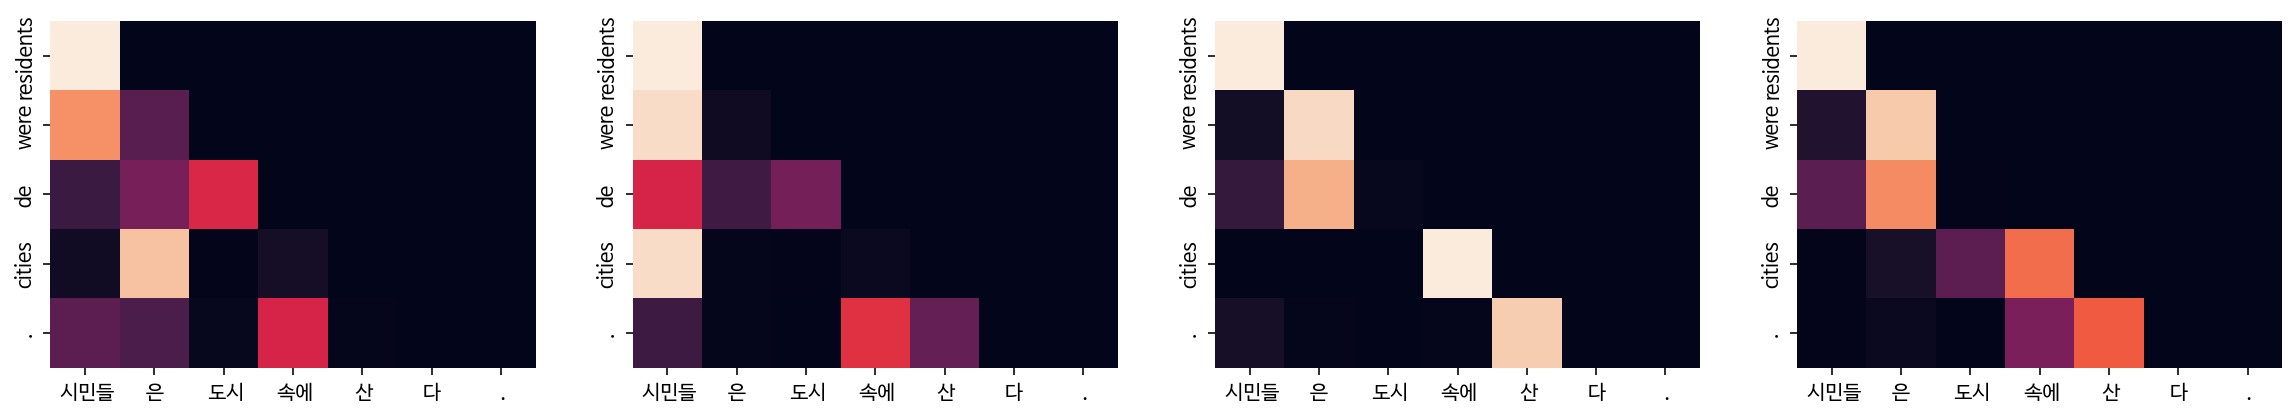

Decoder Self Layer 2


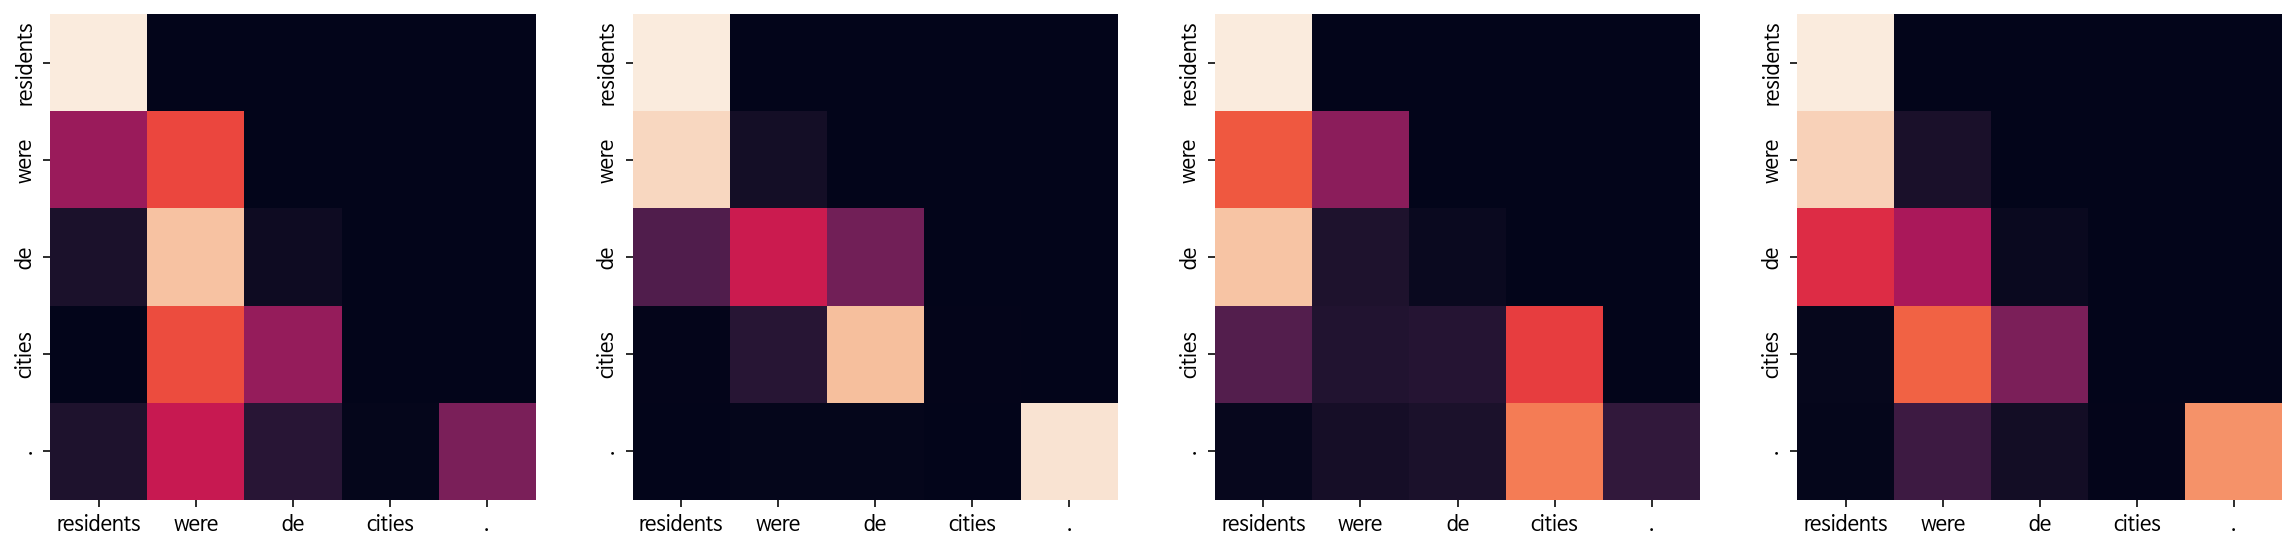

Decoder Src Layer 2


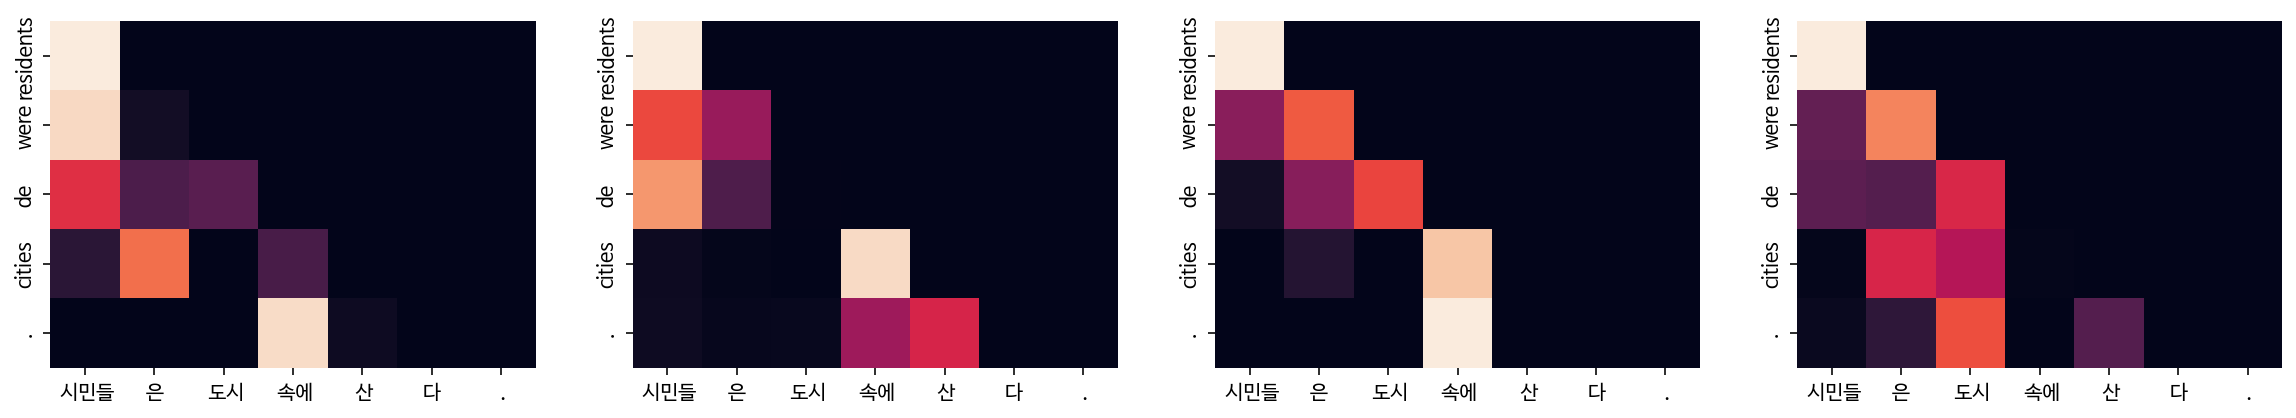

In [40]:
translate('시민들은 도시 속에 산다.',transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were all were by a group .
Encoder Layer 1


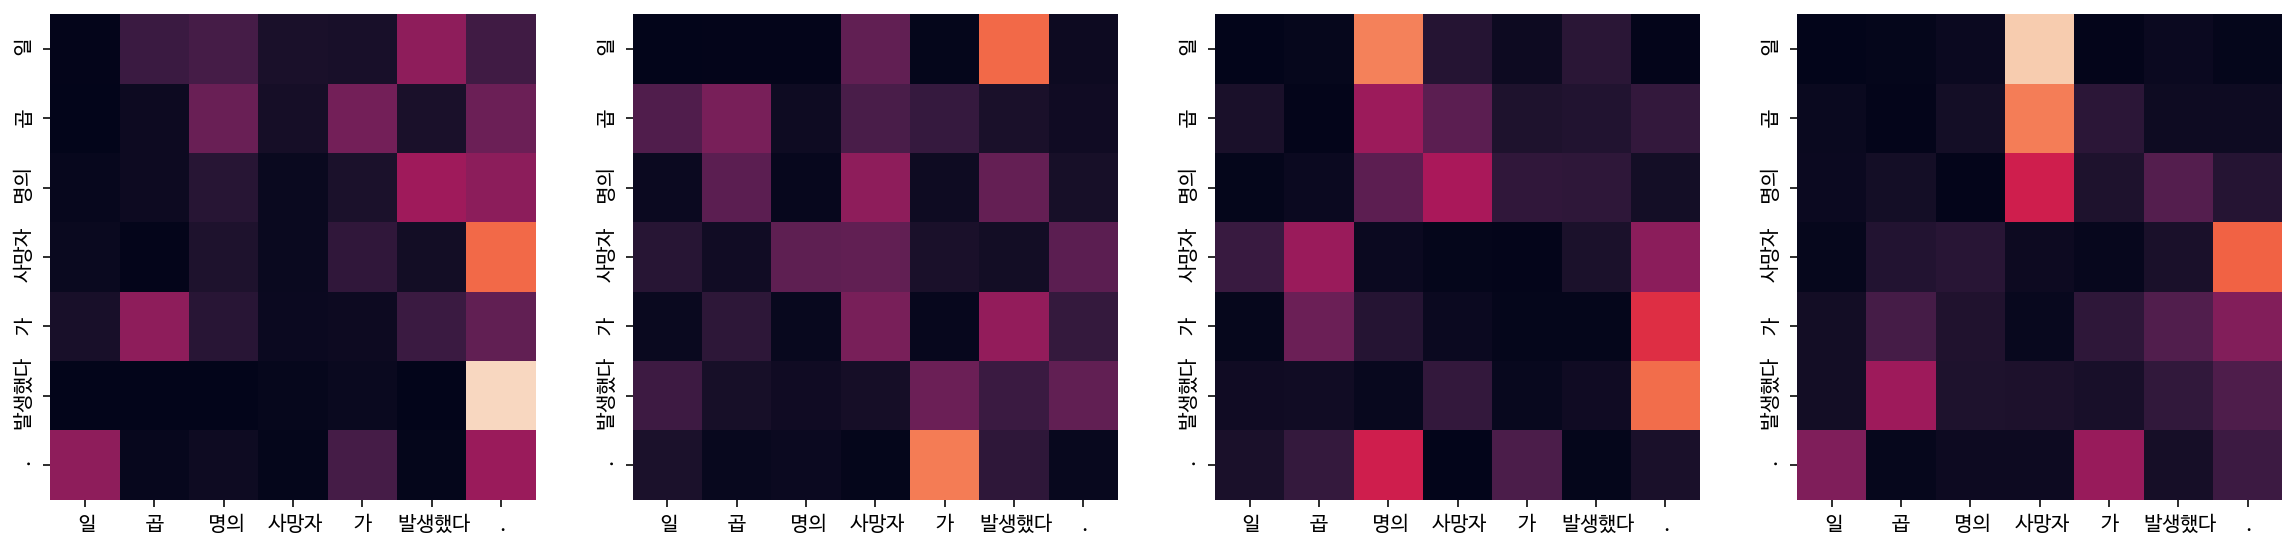

Encoder Layer 2


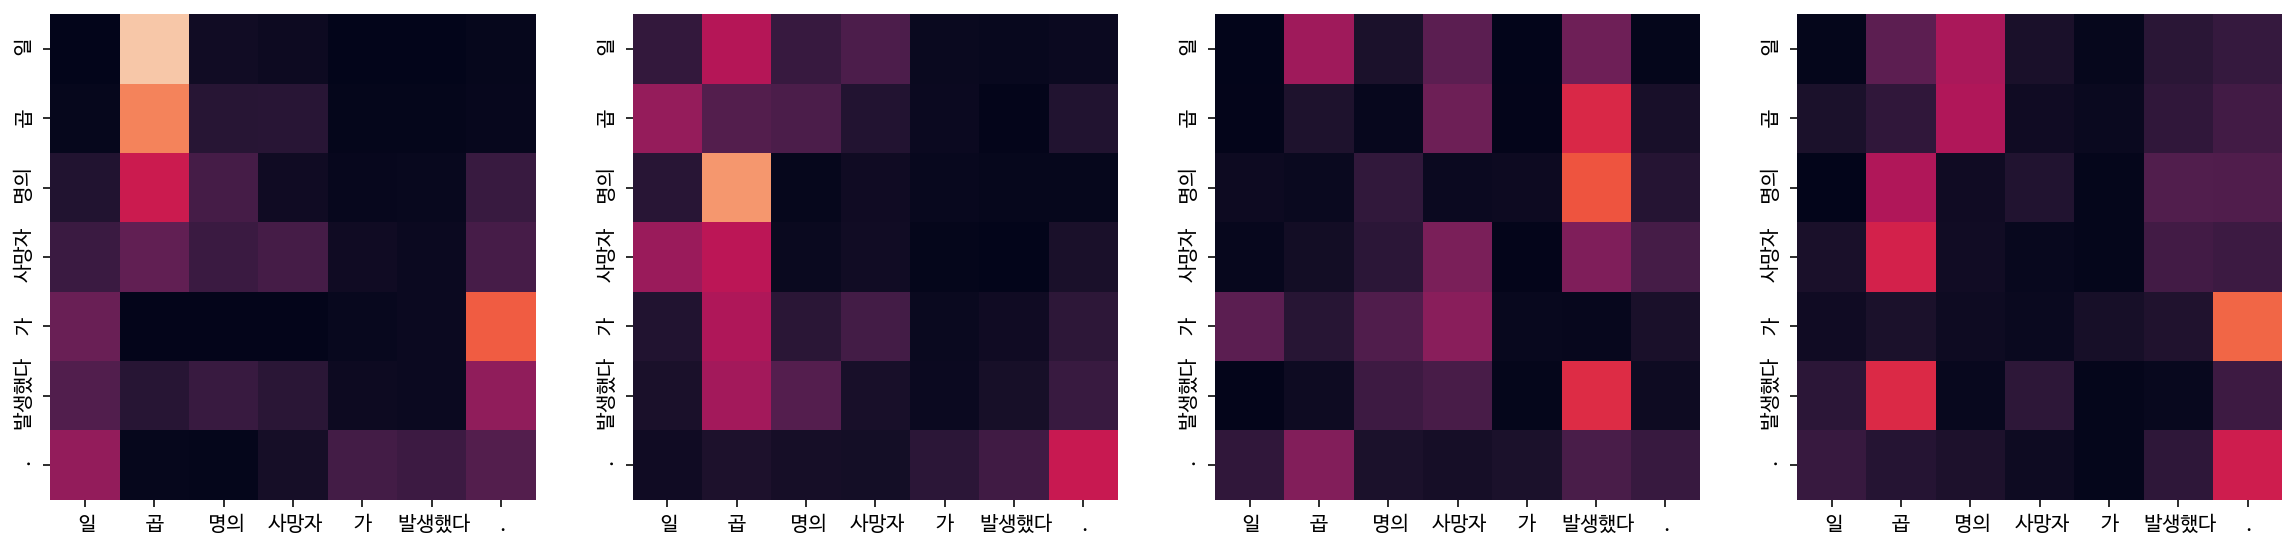

Decoder Self Layer 1


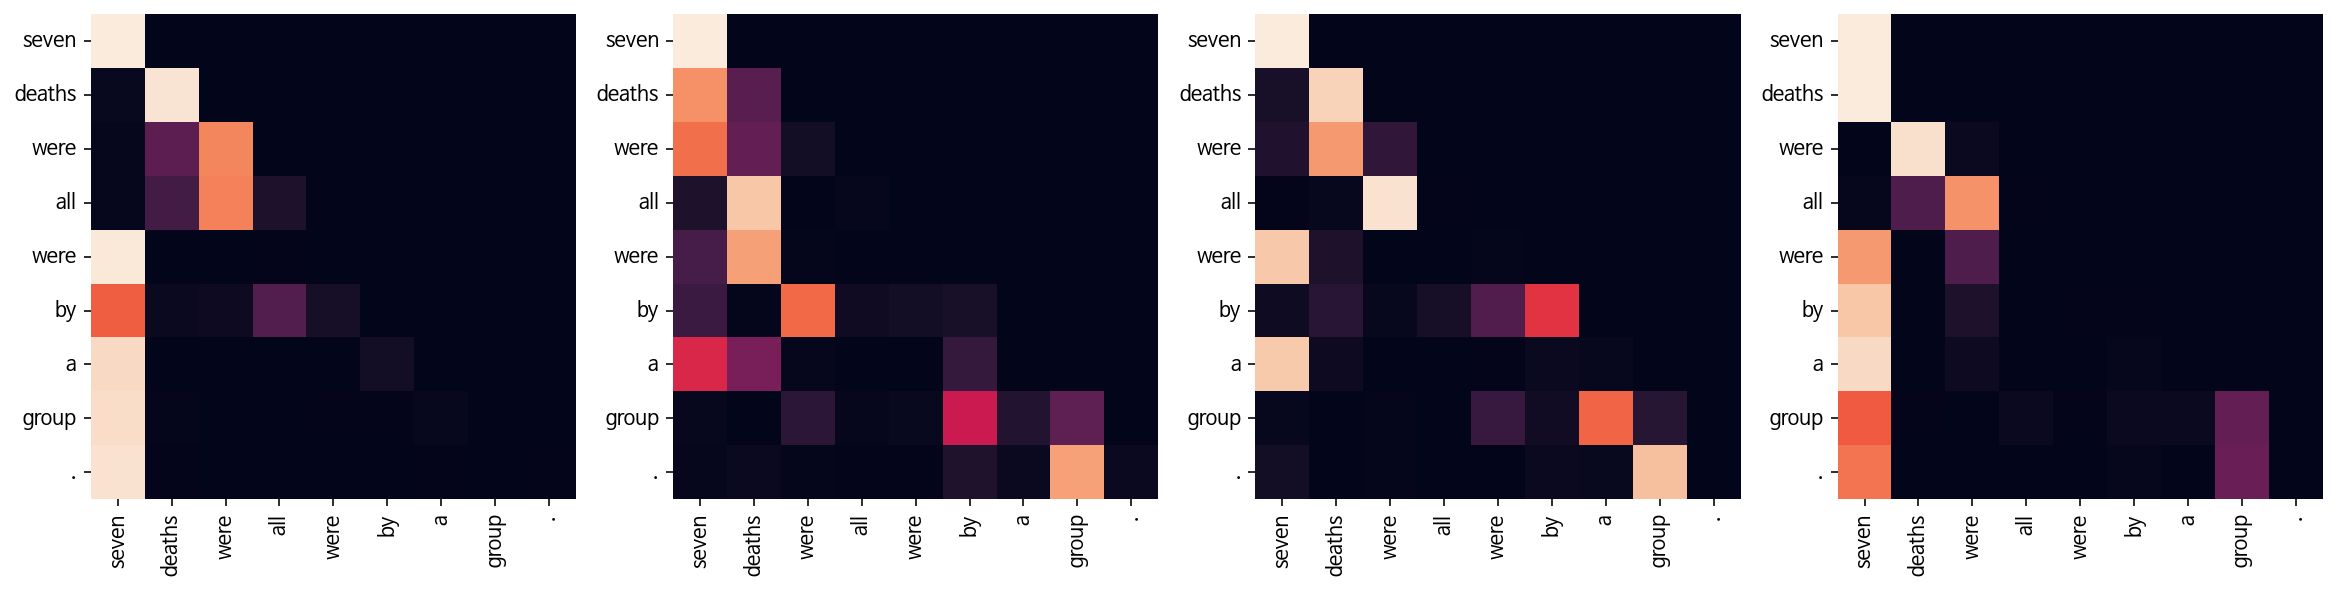

Decoder Src Layer 1


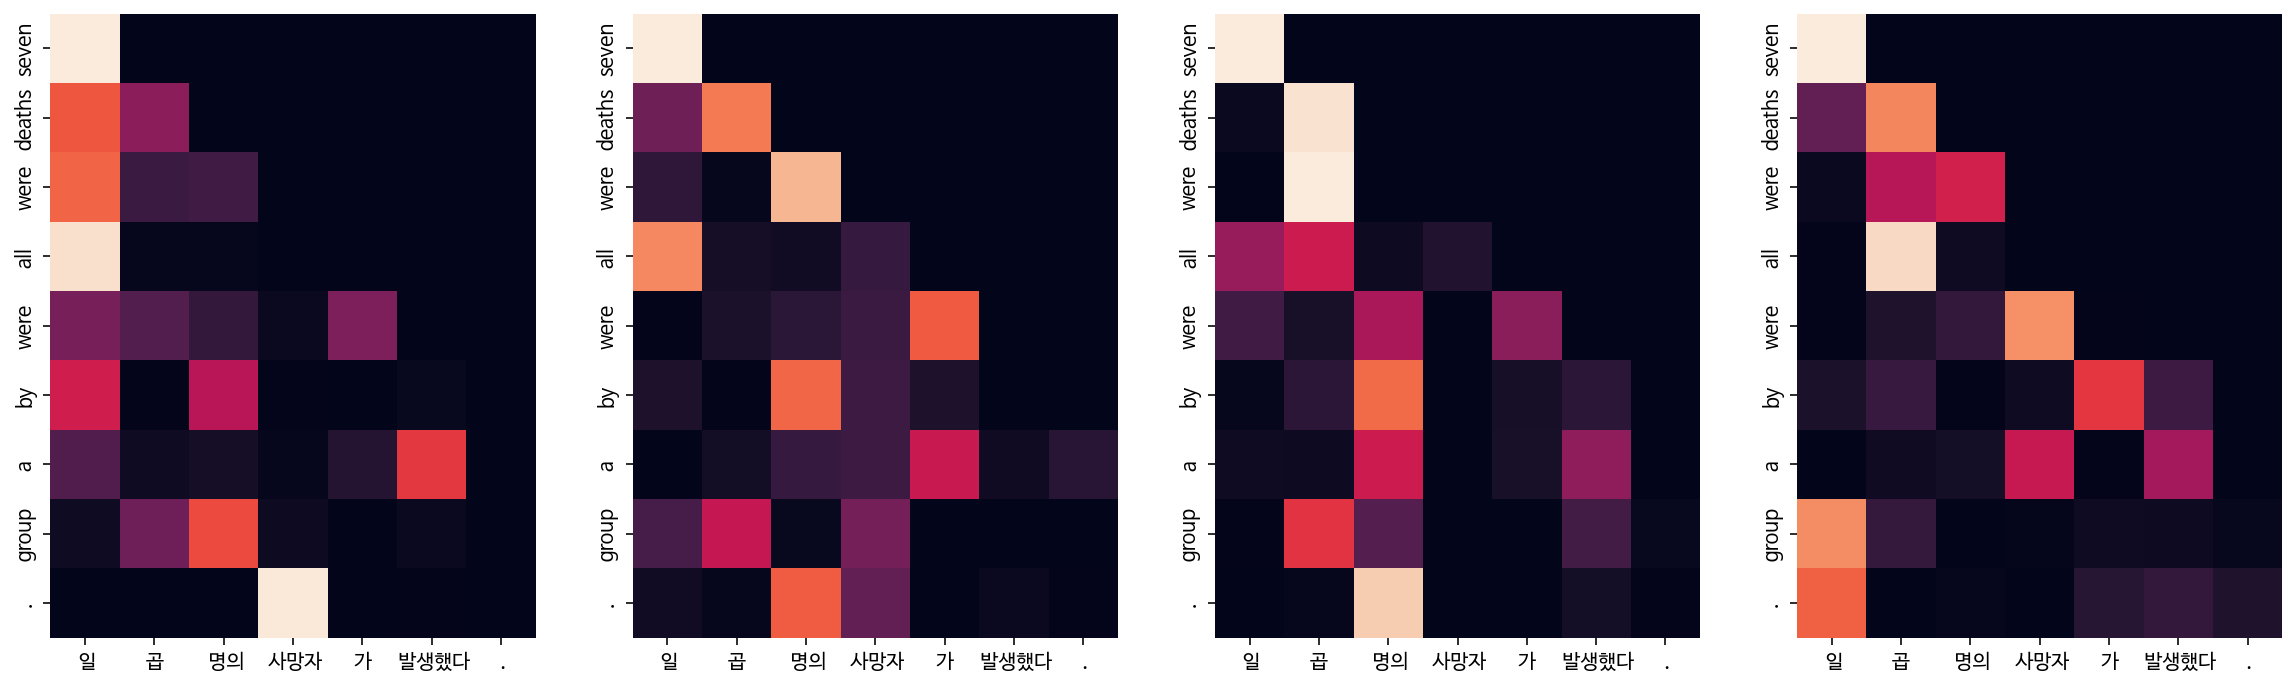

Decoder Self Layer 2


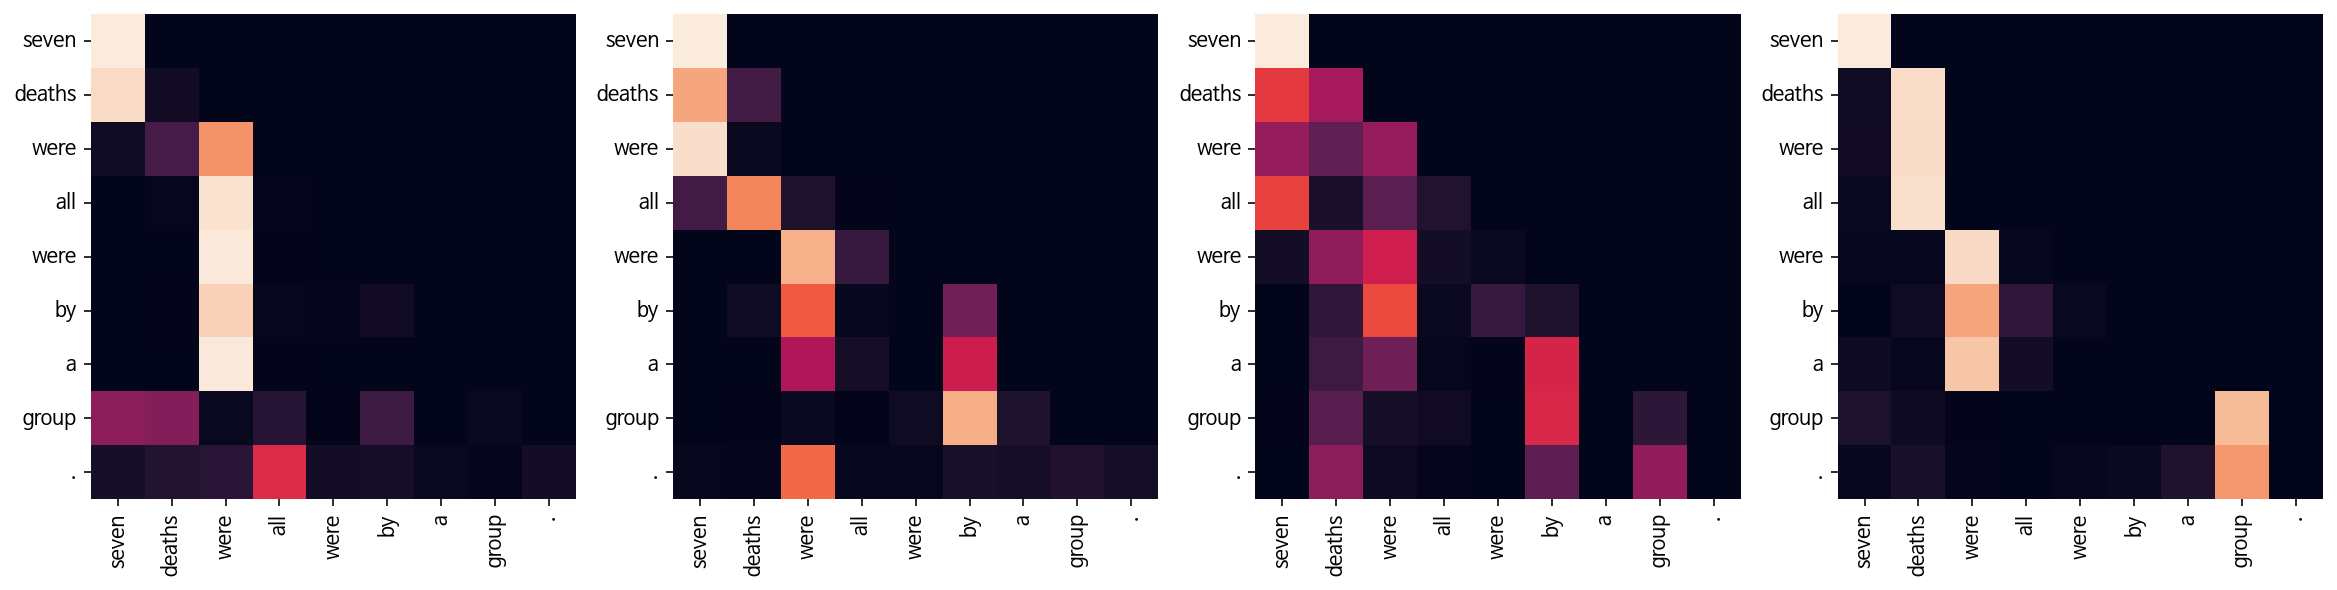

Decoder Src Layer 2


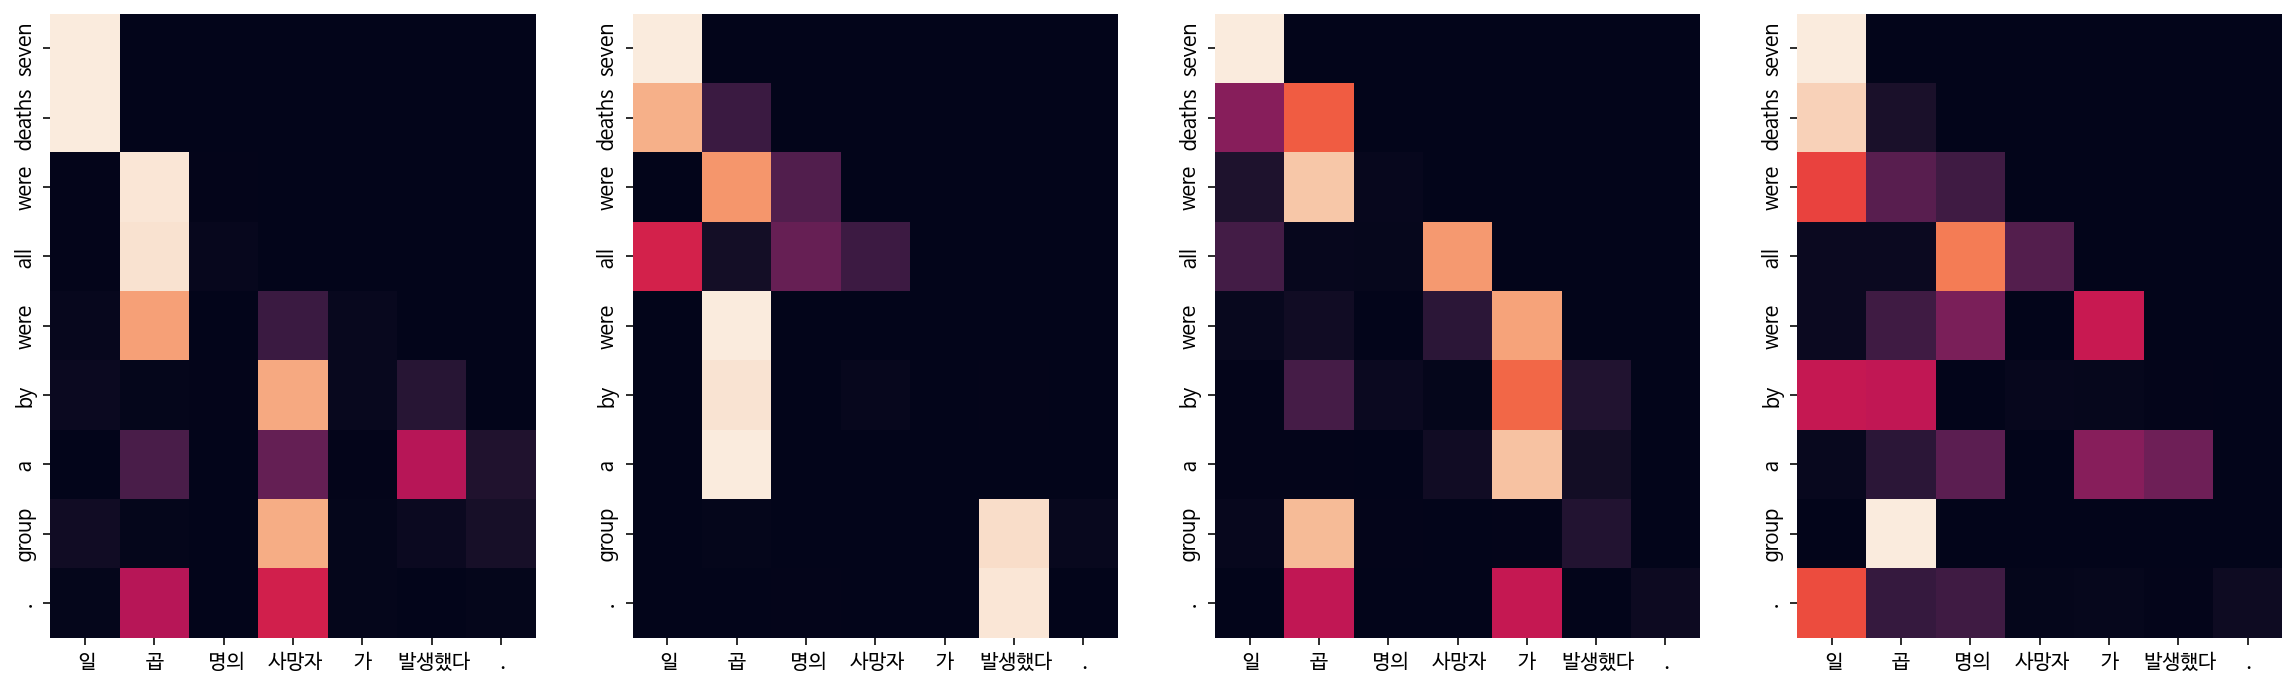

In [42]:
translate('일곱 명의 사망자가 발생했다.',transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

# 회고

- Attention 모델보다 발전된 Transformer를 사용했음에도 불구하고 정확한 번역이 이루어지지 않았다.
- 그래도 결과가 문장으로 나왔다는 것에 의미가 있다 생각한다.
- 모든 문자를 소문자로 바꿔버려서 사람 이름인 오바마를 인식하지 못하고 obamas로 번역한 후 뒤에 동사가 복수형으로 나오는 것이 흥미롭다.
- '일곱 명의 사망자가 발생했다.' 문장에서 일과 곱이 따로 나눠져있는데 seven으로 번역이 된 것도 신기하다.
- VOCAB_SIZE를 20000으로 설정하면 다 담지 못하는지 제대로 번역이 되지 않았다. 그래서 다른 사람이 수행한 깃허브를 참고하여 7000으로 줄였다.

# 참고사이트

[참고깃허브](https://github.com/nevermet/AIFFEL/blob/master/G10_TransformerTranslator.ipynb)